In [17]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [18]:
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'
path3 = '../Data/car_dataset/GE_제네시스/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
for folder, subfolders, filenames in os.walk(path3):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  180588
Image_labels: 180588


In [12]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        if img[24] == 'P':
            continue
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])
            
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  98882
Image_labels: 98882


In [19]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211206_HY_025_18_BL_A_P_01_054.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
1,C_211206_HY_025_18_BL_A_P_01_048.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
2,C_211206_HY_025_18_BL_A_T_02_005.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
3,C_211206_HY_025_18_BL_A_P_01_025.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
4,C_211206_HY_025_18_BL_A_T_03_001.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
...,...,...,...
180583,C_211014_GE_018_20_BL_A_T_03_014.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180584,C_211014_GE_018_20_BL_A_T_03_009.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180585,C_211014_GE_018_20_BL_A_P_01_062.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180586,C_211014_GE_018_20_BL_A_P_01_016.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020


In [14]:
train['label'].value_counts()

벤츠/E-Class/2017       1179
현대/코나/2018             937
기아/모닝/2017             911
기아/K3/2019             875
기아/스포티지/2018           851
                      ... 
쉐보레/말리부/2021            29
현대/벨로스터/2021            29
지프/랭글러/2018             29
BMW/X3/2020             27
미니/Countryman/2021      18
Name: label, Length: 370, dtype: int64

In [20]:
train['label'].value_counts().loc[lambda x : x > 900]

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
현대/코나/2020        940
기아/니로/2018        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [21]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['기아/K5/2021', '기아/K7/2021', '기아/K9/2017', '기아/K9/2018', '기아/니로/2021',
       '기아/레이/2021', '기아/모하비/2019', '기아/모하비/2020', '기아/모하비/2021',
       '기아/봉고3/2018', '기아/봉고3/2019', '기아/봉고3/2020', '기아/봉고3/2021',
       '기아/셀토스/2018', '기아/셀토스/2019', '기아/셀토스/2020', '기아/스토닉/2017',
       '기아/스토닉/2020', '기아/스토닉/2021', '기아/스팅어/2017', '기아/스팅어/2021',
       '기아/스포티지/2020', '기아/스포티지/2021', '기아/쏘울/2017', '기아/쏘울/2018',
       '기아/쏘울/2019', '기아/카니발/2021', '제네시스/EQ900/2019', '제네시스/G70/2020',
       '제네시스/G70/2021', '제네시스/G80/2020', '제네시스/G90/2020', '제네시스/G90/2021',
       '제네시스/GV80/2020', '제네시스/GV80/2021', '현대/i30/2017', '현대/i30/2018',
       '현대/i30/2019', '현대/넥쏘/2020', '현대/맥스크루즈/2017', '현대/맥스크루즈/2018',
       '현대/베뉴/2019', '현대/베뉴/2021', '현대/벨로스터/2017', '현대/벨로스터/2018',
       '현대/벨로스터/2019', '현대/벨로스터/2020', '현대/벨로스터/2021', '현대/스타렉스/2021',
       '현대/싼타페/2021', '현대/아이오닉/2017', '현대/아이오닉/2018', '현대/아이오닉/2019',
       '현대/아이오닉/2020', '현대/아이오닉/2021', '현대/엑센트/2017', '현대/엑센트/2018',
       '현대/엑센트/2019', 

In [22]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018


In [23]:
train['label'].value_counts()

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
기아/니로/2018        940
현대/코나/2020        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [7]:
print(len(train.label))

206646


In [7]:
train.label.nunique()

134

In [24]:
label_value = train['label'].values
label_value

array(['현대/베뉴/2020', '현대/베뉴/2020', '현대/베뉴/2020', ..., '제네시스/G70/2018',
       '제네시스/G70/2018', '제네시스/G70/2018'], dtype=object)

In [25]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53


In [26]:
le.classes_

array(['기아/K3/2017', '기아/K3/2018', '기아/K3/2019', '기아/K3/2020',
       '기아/K3/2021', '기아/K5/2017', '기아/K5/2018', '기아/K5/2019',
       '기아/K5/2020', '기아/K7/2017', '기아/K7/2018', '기아/K7/2019',
       '기아/K7/2020', '기아/K9/2019', '기아/K9/2020', '기아/K9/2021',
       '기아/니로/2017', '기아/니로/2018', '기아/니로/2019', '기아/니로/2020',
       '기아/레이/2017', '기아/레이/2018', '기아/레이/2019', '기아/레이/2020',
       '기아/모닝/2017', '기아/모닝/2018', '기아/모닝/2019', '기아/모닝/2020',
       '기아/모닝/2021', '기아/모하비/2017', '기아/모하비/2018', '기아/봉고3/2017',
       '기아/셀토스/2021', '기아/스토닉/2018', '기아/스토닉/2019', '기아/스팅어/2018',
       '기아/스팅어/2019', '기아/스팅어/2020', '기아/스포티지/2017', '기아/스포티지/2018',
       '기아/스포티지/2019', '기아/쏘렌토/2017', '기아/쏘렌토/2018', '기아/쏘렌토/2019',
       '기아/쏘렌토/2020', '기아/쏘렌토/2021', '기아/카니발/2017', '기아/카니발/2018',
       '기아/카니발/2019', '기아/카니발/2020', '제네시스/EQ900/2017', '제네시스/EQ900/2018',
       '제네시스/G70/2017', '제네시스/G70/2018', '제네시스/G70/2019', '제네시스/G80/2017',
       '제네시스/G80/2018', '제네시스/G80/2019', '제네시스/G80/2021', '제네시스/G90/2019

In [35]:
dist.destroy_process_group()

In [27]:
project_name = 'preprocessed_ef_ns03_HK03'
user = 'hojunking'
run_name = 'preprocessed_ef_ns_03_HK03'

Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 1.1647: 100%|█████████████████| 6544/6544 [27:05<00:00,  4.02it/s]

train accuracy = 0.40380
[[1086  262  110 ...    0    1    2]
 [ 440  581   84 ...    1    1    4]
 [ 120  166  552 ...    2    0    2]
 ...
 [   2    0    2 ...  975  410    3]
 [   3    0    1 ...  604  695   11]
 [   1    0    1 ...    6    6 1745]]



epoch 0 loss: 1.2179: 100%|█████████████████| 1860/1860 [03:17<00:00,  9.41it/s]


validation accuracy = 0.51327
[[179  48  25 ...   0   0   0]
 [ 57  87  33 ...   0   0   0]
 [  7  18 235 ...   0   0   0]
 ...
 [  0   0   0 ...  56  39   1]
 [  0   0   0 ...  39 105   1]
 [  0   0   0 ...   0   0 207]]


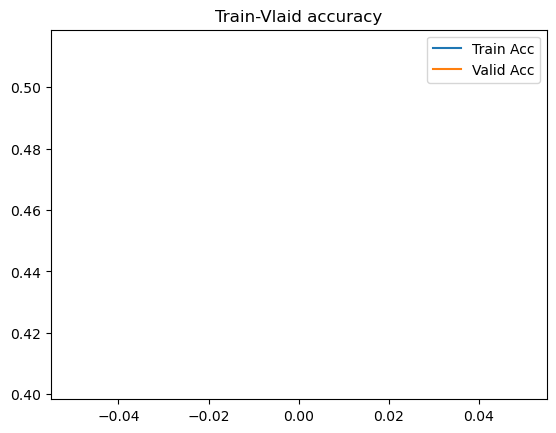

epoch 1 loss: 0.8368: 100%|█████████████████| 6544/6544 [26:40<00:00,  4.09it/s]

train accuracy = 0.62894
[[1535  270  114 ...    0    2    1]
 [ 365 1235  100 ...    0    0    0]
 [  60  160 1025 ...    0    2    1]
 ...
 [   0    0    0 ... 1483  319    0]
 [   0    0    0 ...  501 1301    4]
 [   0    0    0 ...    0    1 2091]]



epoch 1 loss: 1.0345: 100%|█████████████████| 1860/1860 [03:15<00:00,  9.52it/s]


validation accuracy = 0.59069
[[214  33  12 ...   0   0   0]
 [ 55 139   5 ...   1   0   0]
 [ 12  54 181 ...   0   0   0]
 ...
 [  0   0   0 ... 116  20   1]
 [  0   0   0 ...  70 115   1]
 [  0   0   0 ...   0   0 211]]


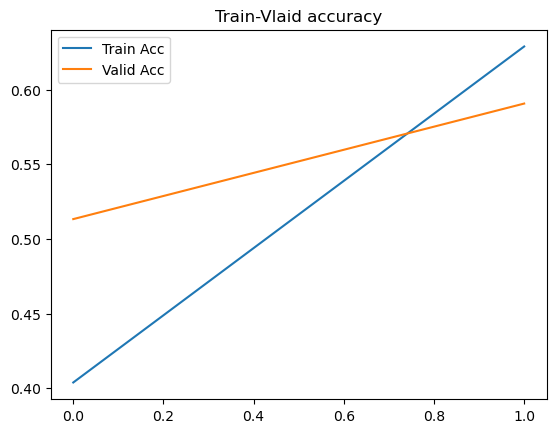

epoch 2 loss: 0.6581: 100%|█████████████████| 6544/6544 [26:34<00:00,  4.10it/s]

train accuracy = 0.72657
[[1751  201   80 ...    0    0    0]
 [ 208 1592  115 ...    0    1    0]
 [  56  189 1294 ...    0    2    0]
 ...
 [   0    0    1 ... 1738  235    0]
 [   0    0    1 ...  329 1590    0]
 [   0    0    0 ...    0    0 2139]]



epoch 2 loss: 0.9102: 100%|█████████████████| 1860/1860 [03:16<00:00,  9.48it/s]


validation accuracy = 0.65168
[[193  70   9 ...   0   0   0]
 [ 13 197   9 ...   0   0   0]
 [ 13  63 261 ...   0   0   0]
 ...
 [  0   0   0 ... 135  30   0]
 [  0   0   0 ...  44 154   1]
 [  0   0   0 ...   0   0 212]]


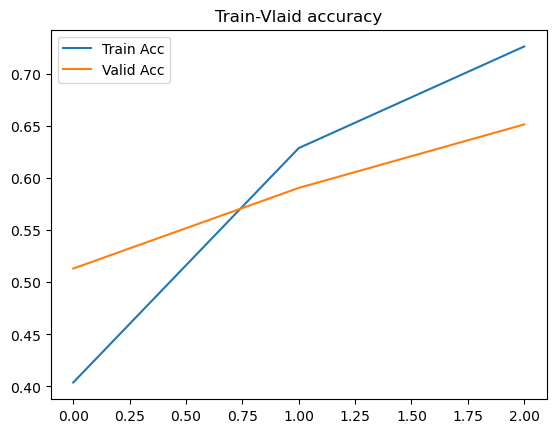

epoch 3 loss: 0.5179: 100%|█████████████████| 6544/6544 [26:44<00:00,  4.08it/s]

train accuracy = 0.79249
[[1920  125   58 ...    0    0    0]
 [ 127 1768  101 ...    1    0    0]
 [  51  163 1488 ...    0    0    0]
 ...
 [   0    0    0 ... 1886  183    0]
 [   1    0    0 ...  218 1811    1]
 [   1    0    0 ...    0    1 2154]]



epoch 3 loss: 0.8598: 100%|█████████████████| 1860/1860 [03:16<00:00,  9.45it/s]


validation accuracy = 0.68706
[[213  40  19 ...   0   0   0]
 [ 15 194  13 ...   0   0   0]
 [ 12  44 283 ...   0   0   0]
 ...
 [  0   0   0 ... 155  12   0]
 [  0   0   0 ...  51 151   1]
 [  0   0   0 ...   0   0 216]]


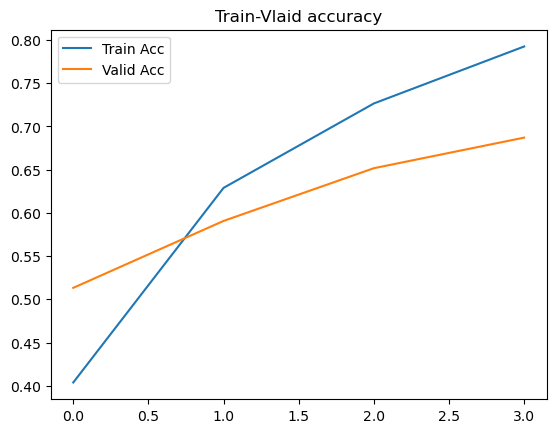

epoch 4 loss: 0.4308: 100%|█████████████████| 6544/6544 [26:44<00:00,  4.08it/s]

train accuracy = 0.83555
[[2015   82   36 ...    0    0    0]
 [  89 1885   97 ...    0    0    0]
 [  27  135 1641 ...    0    0    0]
 ...
 [   0    0    1 ... 1961  138    0]
 [   0    0    0 ...  189 1881    1]
 [   0    0    0 ...    0    0 2161]]



epoch 4 loss: 0.8179: 100%|█████████████████| 1860/1860 [03:17<00:00,  9.43it/s]


validation accuracy = 0.71183
[[239  28  11 ...   0   0   0]
 [ 14 201  20 ...   0   0   0]
 [ 10  47 346 ...   0   0   0]
 ...
 [  0   0   0 ... 144  20   0]
 [  0   0   0 ...  43 153   0]
 [  0   0   0 ...   0   0 213]]


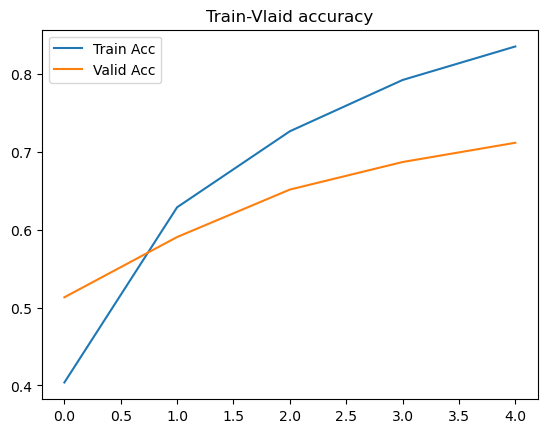

epoch 5 loss: 0.3443: 100%|█████████████████| 6544/6544 [26:46<00:00,  4.07it/s]

train accuracy = 0.86556
[[2030   76   34 ...    0    0    1]
 [  68 1955   73 ...    0    0    0]
 [  28  129 1728 ...    0    0    0]
 ...
 [   0    0    0 ... 2007  120    0]
 [   0    0    0 ...  142 1975    0]
 [   0    0    0 ...    1    0 2163]]



epoch 5 loss: 0.8544: 100%|█████████████████| 1860/1860 [03:17<00:00,  9.41it/s]


validation accuracy = 0.71599
[[231  16  21 ...   0   0   0]
 [ 16 194  16 ...   0   1   0]
 [  4  42 347 ...   0   0   0]
 ...
 [  0   0   0 ... 159   5   0]
 [  0   0   0 ...  49 141   0]
 [  0   0   0 ...   0   0 215]]


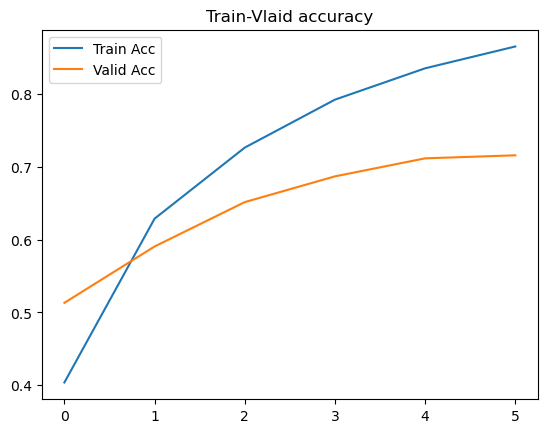

epoch 6 loss: 0.3326: 100%|█████████████████| 6544/6544 [26:47<00:00,  4.07it/s]

train accuracy = 0.88555
[[2081   45   21 ...    0    0    0]
 [  46 1963   89 ...    0    1    0]
 [  23  136 1776 ...    0    1    0]
 ...
 [   0    0    2 ... 2034   95    1]
 [   0    0    0 ...  122 1983    2]
 [   0    0    0 ...    0    1 2170]]



epoch 6 loss: 0.8025: 100%|█████████████████| 1860/1860 [03:18<00:00,  9.39it/s]


validation accuracy = 0.74019
[[259  12  11 ...   0   0   0]
 [ 22 210  13 ...   0   0   0]
 [ 11  51 325 ...   0   0   0]
 ...
 [  0   0   0 ... 159  10   0]
 [  0   0   0 ...  46 161   0]
 [  0   0   0 ...   0   0 217]]


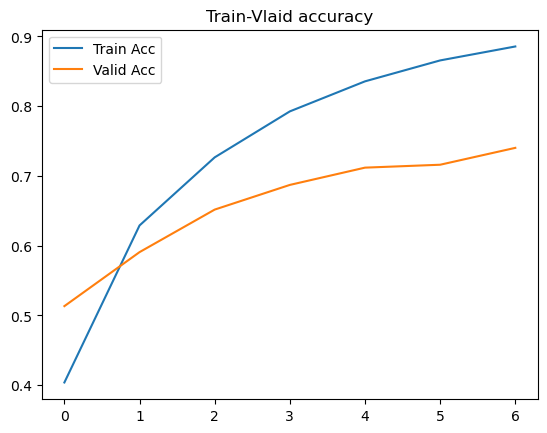

epoch 7 loss: 0.2780: 100%|█████████████████| 6544/6544 [26:49<00:00,  4.07it/s]

train accuracy = 0.90131
[[2088   35   36 ...    0    1    0]
 [  34 2016   74 ...    0    0    0]
 [  32  113 1813 ...    0    0    0]
 ...
 [   0    0    0 ... 2074   71    1]
 [   0    0    0 ...   89 2049    0]
 [   0    0    0 ...    0    1 2171]]



epoch 7 loss: 0.8210: 100%|█████████████████| 1860/1860 [03:18<00:00,  9.36it/s]


validation accuracy = 0.74674
[[241  23  16 ...   0   0   0]
 [ 12 193  26 ...   0   0   0]
 [  5  33 364 ...   0   0   0]
 ...
 [  0   0   0 ... 157  10   0]
 [  0   0   0 ...  51 148   0]
 [  0   0   0 ...   0   0 212]]


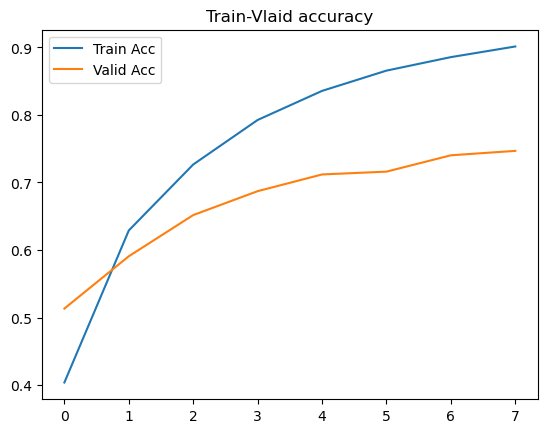

epoch 8 loss: 0.2350: 100%|█████████████████| 6544/6544 [26:39<00:00,  4.09it/s]

train accuracy = 0.91267
[[2089   48   21 ...    0    0    0]
 [  43 2023   54 ...    0    0    0]
 [  17   92 1875 ...    0    0    0]
 ...
 [   0    0    0 ... 2058   81    0]
 [   0    0    0 ...  102 2039    0]
 [   0    0    0 ...    0    0 2181]]



epoch 8 loss: 0.7891: 100%|█████████████████| 1860/1860 [03:16<00:00,  9.44it/s]


validation accuracy = 0.76200
[[253  12   7 ...   0   0   0]
 [ 10 215  18 ...   0   1   0]
 [ 11  43 374 ...   0   0   0]
 ...
 [  0   0   0 ... 151  19   0]
 [  0   0   0 ...  35 178   0]
 [  0   0   0 ...   0   0 216]]


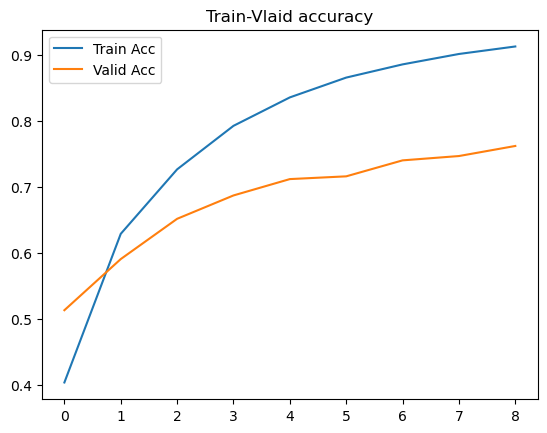

epoch 9 loss: 0.2345: 100%|█████████████████| 6544/6544 [26:57<00:00,  4.05it/s]

train accuracy = 0.92169
[[2113   33   11 ...    0    0    0]
 [  42 2033   64 ...    0    0    0]
 [  11   92 1906 ...    0    0    0]
 ...
 [   0    0    0 ... 2104   60    0]
 [   0    0    0 ...   72 2074    0]
 [   0    0    0 ...    0    0 2179]]



epoch 9 loss: 0.8021: 100%|█████████████████| 1860/1860 [03:17<00:00,  9.43it/s]


validation accuracy = 0.76710
[[227  28  18 ...   0   0   0]
 [ 10 217  21 ...   0   1   0]
 [  6  45 386 ...   0   0   0]
 ...
 [  0   0   0 ... 160   8   0]
 [  0   0   0 ...  47 163   1]
 [  0   0   0 ...   0   0 220]]


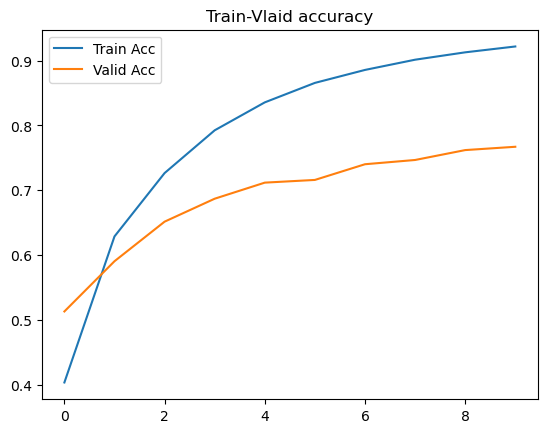

epoch 10 loss: 0.1943: 100%|████████████████| 6544/6544 [26:46<00:00,  4.07it/s]

train accuracy = 0.92836
[[2107   35   20 ...    0    0    0]
 [  27 2071   51 ...    0    0    0]
 [  14   79 1918 ...    1    0    0]
 ...
 [   0    0    0 ... 2095   64    0]
 [   0    0    0 ...   76 2077    0]
 [   0    0    0 ...    0    0 2187]]



epoch 10 loss: 0.8459: 100%|████████████████| 1860/1860 [03:18<00:00,  9.38it/s]


validation accuracy = 0.76233
[[251  14  16 ...   0   0   0]
 [ 10 206  18 ...   0   0   0]
 [  6  42 372 ...   0   0   0]
 ...
 [  0   0   0 ... 165   5   0]
 [  0   0   0 ...  53 152   0]
 [  0   0   0 ...   0   0 215]]


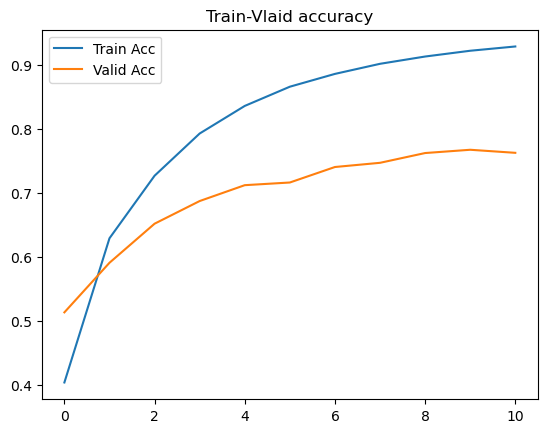

epoch 11 loss: 0.1961: 100%|████████████████| 6544/6544 [26:45<00:00,  4.08it/s]

train accuracy = 0.93424
[[2135   27   13 ...    0    0    0]
 [  28 2073   53 ...    1    0    0]
 [  10   77 1933 ...    0    0    0]
 ...
 [   0    0    0 ... 2112   51    0]
 [   0    0    2 ...   69 2071    0]
 [   0    0    0 ...    2    1 2185]]



epoch 11 loss: 0.8025: 100%|████████████████| 1860/1860 [03:18<00:00,  9.37it/s]


validation accuracy = 0.77157
[[268   4  14 ...   0   0   0]
 [ 11 190  46 ...   0   0   0]
 [  3  31 424 ...   0   0   0]
 ...
 [  0   0   0 ... 167   5   0]
 [  0   0   0 ...  43 166   0]
 [  0   0   0 ...   0   0 217]]


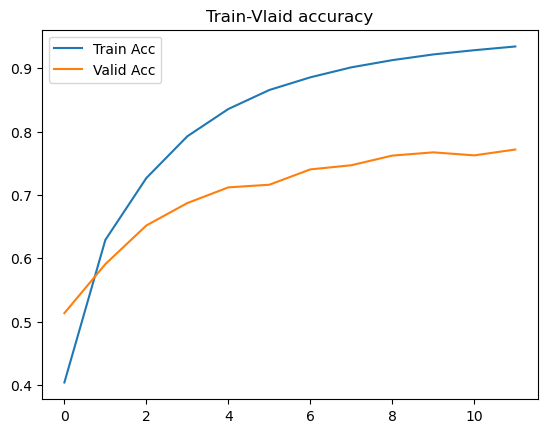

epoch 12 loss: 0.1847: 100%|████████████████| 6544/6544 [26:51<00:00,  4.06it/s]

train accuracy = 0.93918
[[2147   18   11 ...    0    0    0]
 [  15 2077   58 ...    0    0    0]
 [   7   70 1972 ...    0    0    0]
 ...
 [   0    0    0 ... 2111   58    0]
 [   0    0    0 ...   60 2094    0]
 [   0    0    0 ...    0    0 2187]]



epoch 12 loss: 0.7894: 100%|████████████████| 1860/1860 [03:19<00:00,  9.34it/s]


validation accuracy = 0.78004
[[260  14  13 ...   0   0   0]
 [ 10 203  31 ...   0   0   0]
 [  7  31 401 ...   0   0   0]
 ...
 [  0   0   0 ... 170   7   0]
 [  1   0   0 ...  39 166   0]
 [  0   0   0 ...   0   0 215]]


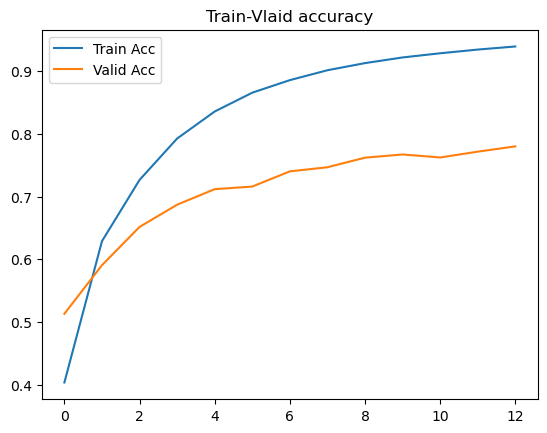

epoch 13 loss: 0.1723: 100%|████████████████| 6544/6544 [27:01<00:00,  4.04it/s]

train accuracy = 0.94353
[[2142   30    7 ...    0    0    0]
 [  25 2078   48 ...    0    0    0]
 [   6   65 1989 ...    0    0    0]
 ...
 [   0    0    0 ... 2130   40    0]
 [   1    0    0 ...   58 2097    0]
 [   0    0    0 ...    3    0 2178]]



epoch 13 loss: 0.7866: 100%|████████████████| 1860/1860 [03:19<00:00,  9.32it/s]


validation accuracy = 0.78343
[[247  20  13 ...   0   0   0]
 [  8 211  18 ...   0   1   0]
 [  1  39 389 ...   0   1   0]
 ...
 [  0   0   0 ... 165   6   0]
 [  0   0   0 ...  39 174   0]
 [  0   0   0 ...   0   0 221]]


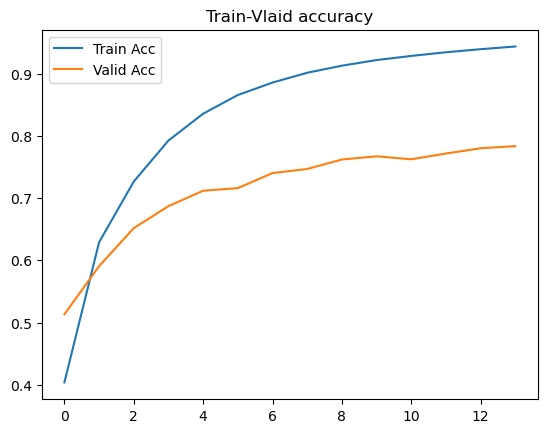

epoch 14 loss: 0.1702: 100%|████████████████| 6544/6544 [26:51<00:00,  4.06it/s]

train accuracy = 0.94803
[[2132   21   11 ...    0    0    1]
 [  26 2093   37 ...    0    1    0]
 [   7   58 1994 ...    0    0    0]
 ...
 [   0    0    0 ... 2134   41    0]
 [   0    0    0 ...   55 2099    0]
 [   0    0    0 ...    0    0 2182]]



epoch 14 loss: 0.8182: 100%|████████████████| 1860/1860 [03:20<00:00,  9.29it/s]


validation accuracy = 0.78112
[[263   6  11 ...   0   0   0]
 [ 18 191  33 ...   0   1   0]
 [ 17  38 379 ...   0   0   0]
 ...
 [  0   0   0 ... 165  12   0]
 [  0   0   0 ...  35 180   0]
 [  0   0   0 ...   0   0 220]]


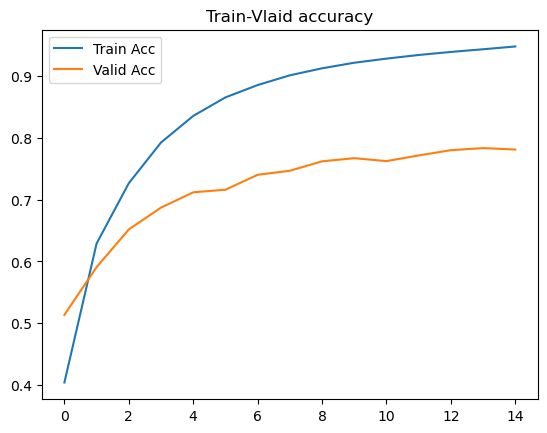

epoch 15 loss: 0.1628: 100%|████████████████| 6544/6544 [27:00<00:00,  4.04it/s]

train accuracy = 0.95041
[[2152   12    9 ...    0    0    0]
 [  18 2108   33 ...    0    0    0]
 [  10   61 1996 ...    0    1    0]
 ...
 [   0    0    0 ... 2126   48    1]
 [   0    0    0 ...   61 2101    0]
 [   0    0    0 ...    0    0 2183]]



epoch 15 loss: 0.8499: 100%|████████████████| 1860/1860 [03:20<00:00,  9.27it/s]


validation accuracy = 0.78014
[[250  10  16 ...   0   0   0]
 [ 15 198  41 ...   0   1   0]
 [  5  29 427 ...   0   0   0]
 ...
 [  0   0   0 ... 174   6   0]
 [  0   0   0 ...  49 162   0]
 [  0   0   0 ...   0   0 220]]


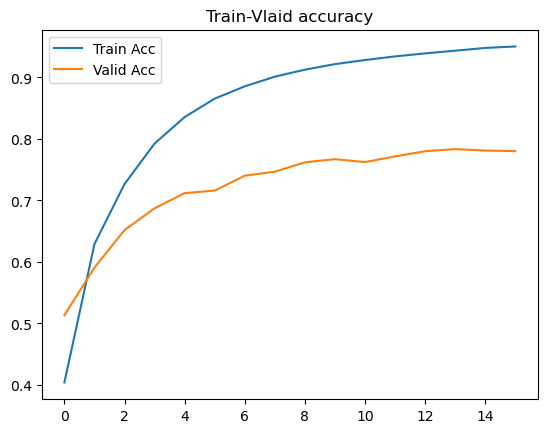

epoch 16 loss: 0.1497: 100%|████████████████| 6544/6544 [27:10<00:00,  4.01it/s]

train accuracy = 0.95322
[[2156   17    5 ...    0    0    0]
 [  17 2102   40 ...    0    0    0]
 [   7   54 2010 ...    0    0    0]
 ...
 [   0    0    0 ... 2128   41    0]
 [   0    0    0 ...   50 2119    0]
 [   0    0    0 ...    0    0 2185]]



epoch 16 loss: 0.8712: 100%|████████████████| 1860/1860 [03:20<00:00,  9.26it/s]


validation accuracy = 0.78575
[[256  10  19 ...   0   0   0]
 [ 13 208  19 ...   0   0   0]
 [  3  45 372 ...   0   0   0]
 ...
 [  0   0   0 ... 169   9   0]
 [  1   0   0 ...  50 162   1]
 [  0   0   0 ...   0   0 218]]


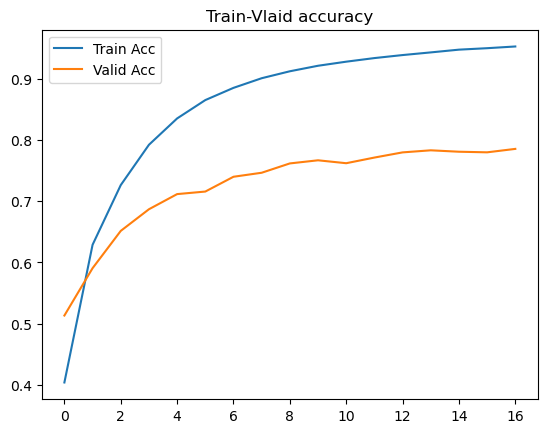

epoch 17 loss: 0.1245: 100%|████████████████| 6544/6544 [26:58<00:00,  4.04it/s]

train accuracy = 0.95603
[[2142   23    8 ...    0    0    0]
 [  19 2116   31 ...    0    0    1]
 [   5   55 2024 ...    0    0    0]
 ...
 [   0    0    0 ... 2134   40    0]
 [   0    0    0 ...   41 2124    0]
 [   0    0    0 ...    1    0 2187]]



epoch 17 loss: 0.8386: 100%|████████████████| 1860/1860 [03:22<00:00,  9.21it/s]


validation accuracy = 0.79042
[[253  19   5 ...   0   0   0]
 [  7 195  34 ...   0   0   0]
 [  4  34 408 ...   0   0   0]
 ...
 [  0   0   0 ... 176   2   0]
 [  0   0   0 ...  63 140   0]
 [  0   0   0 ...   0   0 218]]


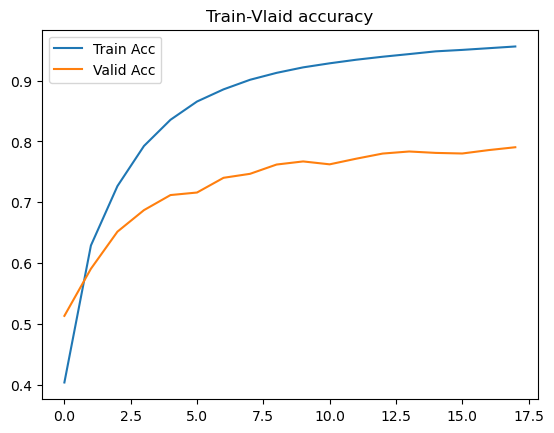

epoch 18 loss: 0.1416: 100%|████████████████| 6544/6544 [27:02<00:00,  4.03it/s]

train accuracy = 0.95729
[[2155   18    8 ...    0    0    0]
 [  14 2128   32 ...    0    0    0]
 [   8   42 2019 ...    0    0    0]
 ...
 [   0    0    0 ... 2138   47    0]
 [   0    0    0 ...   44 2116    0]
 [   0    0    0 ...    0    0 2191]]



epoch 18 loss: 0.8229: 100%|████████████████| 1860/1860 [03:22<00:00,  9.19it/s]


validation accuracy = 0.79640
[[253  14  13 ...   0   0   0]
 [  8 193  36 ...   0   0   0]
 [  3  24 423 ...   0   0   0]
 ...
 [  0   0   0 ... 170   7   0]
 [  0   0   0 ...  34 172   0]
 [  0   0   0 ...   0   0 218]]


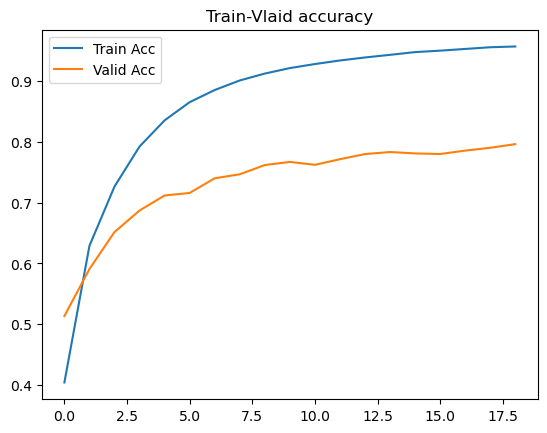

epoch 19 loss: 0.1512: 100%|████████████████| 6544/6544 [27:05<00:00,  4.03it/s]

train accuracy = 0.96022
[[2161   13    5 ...    0    0    0]
 [  11 2136   29 ...    0    0    0]
 [   5   42 2051 ...    1    0    0]
 ...
 [   0    0    0 ... 2153   32    0]
 [   0    0    0 ...   35 2130    0]
 [   0    0    0 ...    0    0 2184]]



epoch 19 loss: 0.8385: 100%|████████████████| 1860/1860 [03:22<00:00,  9.17it/s]


validation accuracy = 0.79264
[[259   7  10 ...   0   0   0]
 [  7 218  21 ...   0   1   0]
 [  4  47 401 ...   0   0   0]
 ...
 [  0   0   0 ... 166   9   1]
 [  0   0   0 ...  27 174   0]
 [  0   0   0 ...   0   0 216]]


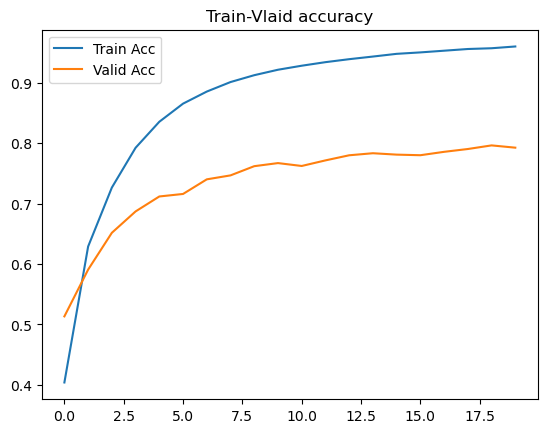

epoch 20 loss: 0.1102: 100%|████████████████| 6544/6544 [27:07<00:00,  4.02it/s]

train accuracy = 0.96145
[[2167   13    4 ...    0    0    0]
 [  17 2126   23 ...    0    0    0]
 [   4   39 2041 ...    0    0    2]
 ...
 [   0    0    0 ... 2143   39    0]
 [   0    0    0 ...   44 2128    0]
 [   0    0    0 ...    0    0 2191]]



epoch 20 loss: 0.8174: 100%|████████████████| 1860/1860 [03:23<00:00,  9.12it/s]


validation accuracy = 0.79701
[[265  10   6 ...   0   0   0]
 [  8 192  42 ...   0   1   0]
 [  4  32 405 ...   0   0   0]
 ...
 [  0   0   0 ... 151  20   0]
 [  0   0   0 ...  25 186   0]
 [  0   0   0 ...   0   0 217]]


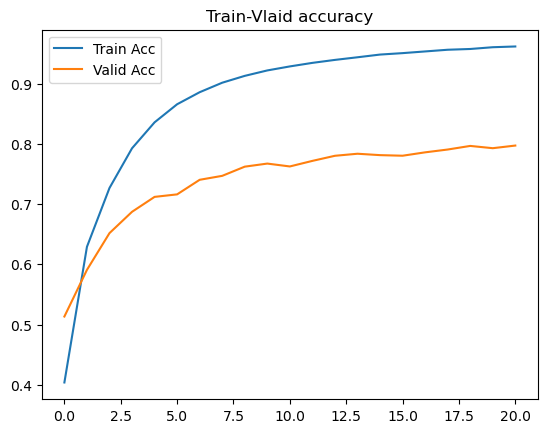

epoch 21 loss: 0.1248: 100%|████████████████| 6544/6544 [27:08<00:00,  4.02it/s]

train accuracy = 0.96408
[[2165   16    3 ...    0    0    0]
 [  13 2128   27 ...    0    1    0]
 [   3   38 2067 ...    0    0    0]
 ...
 [   0    0    0 ... 2141   39    0]
 [   0    0    0 ...   37 2144    0]
 [   0    0    1 ...    0    0 2190]]



epoch 21 loss: 0.8497: 100%|████████████████| 1860/1860 [03:23<00:00,  9.15it/s]


validation accuracy = 0.79587
[[252  12  13 ...   0   0   0]
 [  4 199  45 ...   0   0   0]
 [  5  29 425 ...   0   0   0]
 ...
 [  0   0   0 ... 166   7   0]
 [  0   0   0 ...  44 170   0]
 [  0   0   0 ...   0   0 217]]


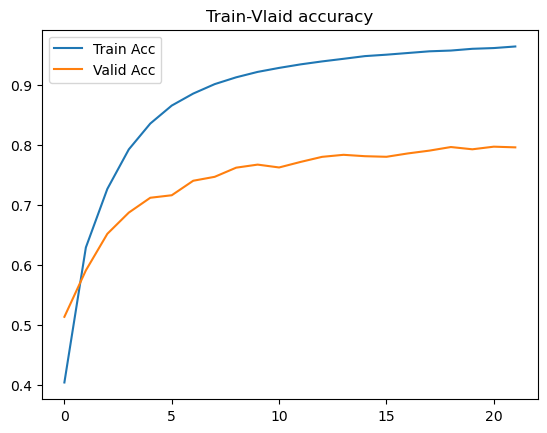

epoch 22 loss: 0.0980: 100%|████████████████| 6544/6544 [27:05<00:00,  4.02it/s]

train accuracy = 0.96411
[[2161   12    6 ...    0    0    0]
 [  11 2140   26 ...    0    0    0]
 [   5   28 2075 ...    0    0    0]
 ...
 [   0    0    0 ... 2150   34    0]
 [   0    0    1 ...   47 2132    0]
 [   0    0    0 ...    0    0 2195]]



epoch 22 loss: 0.8668: 100%|████████████████| 1860/1860 [03:24<00:00,  9.11it/s]


validation accuracy = 0.79637
[[270   4   7 ...   0   0   0]
 [ 10 210  30 ...   0   1   0]
 [ 10  40 383 ...   0   0   0]
 ...
 [  0   0   0 ... 159  14   0]
 [  1   0   0 ...  28 181   0]
 [  0   0   0 ...   0   0 220]]


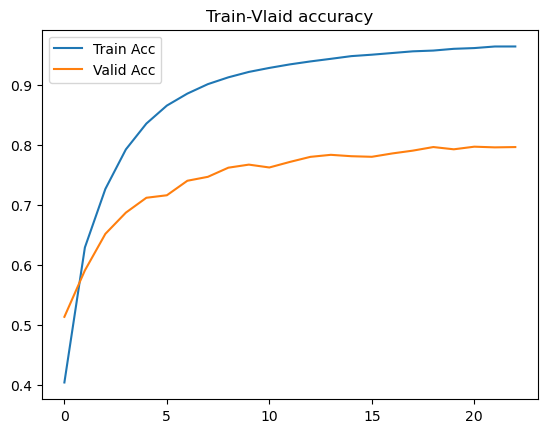

epoch 23 loss: 0.1241: 100%|████████████████| 6544/6544 [27:07<00:00,  4.02it/s]

train accuracy = 0.96564
[[2162   13    6 ...    0    0    0]
 [  13 2132   24 ...    0    0    0]
 [   0   39 2075 ...    0    0    0]
 ...
 [   0    0    0 ... 2159   24    0]
 [   0    0    0 ...   33 2140    0]
 [   0    0    0 ...    2    0 2190]]



epoch 23 loss: 0.8103: 100%|████████████████| 1860/1860 [03:23<00:00,  9.14it/s]


validation accuracy = 0.80400
[[284   3   1 ...   0   0   0]
 [ 13 194  42 ...   0   1   0]
 [  8  26 425 ...   0   0   0]
 ...
 [  0   0   0 ... 169   7   1]
 [  0   0   0 ...  40 172   0]
 [  0   0   0 ...   0   0 217]]


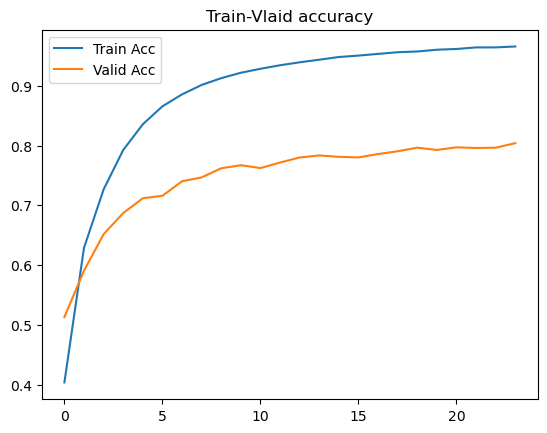

epoch 24 loss: 0.1122: 100%|████████████████| 6544/6544 [27:16<00:00,  4.00it/s]


train accuracy = 0.96722
[[2159    9    7 ...    0    0    0]
 [  10 2129   34 ...    0    0    0]
 [   7   33 2055 ...    1    0    0]
 ...
 [   0    0    0 ... 2141   37    1]
 [   0    0    0 ...   40 2150    0]
 [   0    0    0 ...    0    0 2191]]


epoch 24 loss: 0.8213: 100%|████████████████| 1860/1860 [03:24<00:00,  9.11it/s]


validation accuracy = 0.80780
[[267  11   5 ...   0   0   0]
 [ 11 215  18 ...   0   1   0]
 [  9  44 388 ...   0   0   0]
 ...
 [  0   0   0 ... 171   6   0]
 [  1   0   0 ...  42 161   1]
 [  0   0   0 ...   1   0 216]]


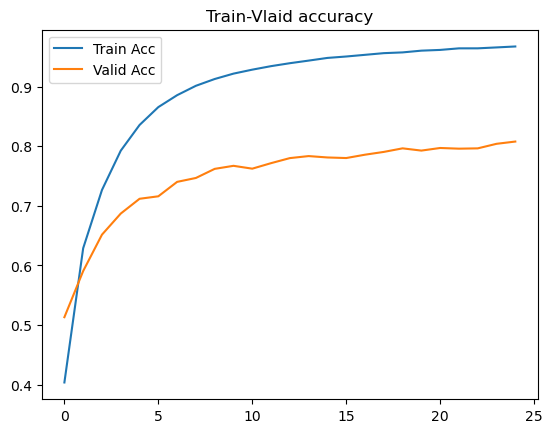

epoch 25 loss: 0.0667: 100%|████████████████| 6544/6544 [27:07<00:00,  4.02it/s]

train accuracy = 0.97623
[[2182    6    4 ...    0    0    0]
 [   8 2150   25 ...    0    0    0]
 [   4   38 2084 ...    0    1    0]
 ...
 [   0    0    0 ... 2172   24    0]
 [   0    0    0 ...   24 2160    0]
 [   0    0    0 ...    0    0 2195]]



epoch 25 loss: 0.7964: 100%|████████████████| 1860/1860 [03:23<00:00,  9.14it/s]


validation accuracy = 0.81657
[[273   4   9 ...   0   0   0]
 [ 10 200  39 ...   0   1   0]
 [  5  43 405 ...   0   0   0]
 ...
 [  0   0   0 ... 163  12   0]
 [  0   0   0 ...  26 178   0]
 [  0   0   0 ...   1   0 215]]


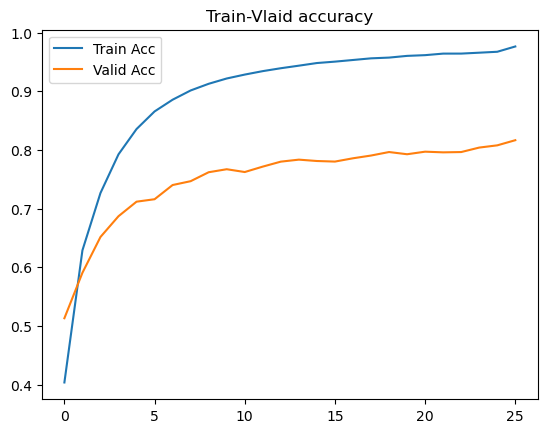

epoch 26 loss: 0.0709: 100%|████████████████| 6544/6544 [27:15<00:00,  4.00it/s]


train accuracy = 0.97957
[[2188    1    0 ...    0    0    0]
 [   5 2161   21 ...    0    0    0]
 [   1   29 2109 ...    0    0    0]
 ...
 [   0    0    0 ... 2167   28    0]
 [   0    0    0 ...   26 2161    0]
 [   0    0    0 ...    0    1 2198]]


epoch 26 loss: 0.8353: 100%|████████████████| 1860/1860 [03:23<00:00,  9.14it/s]


validation accuracy = 0.81835
[[274   7   4 ...   0   0   0]
 [  5 198  40 ...   0   0   0]
 [ 13  31 417 ...   0   0   0]
 ...
 [  0   0   0 ... 162  11   0]
 [  1   0   0 ...  27 182   0]
 [  0   0   0 ...   0   0 215]]


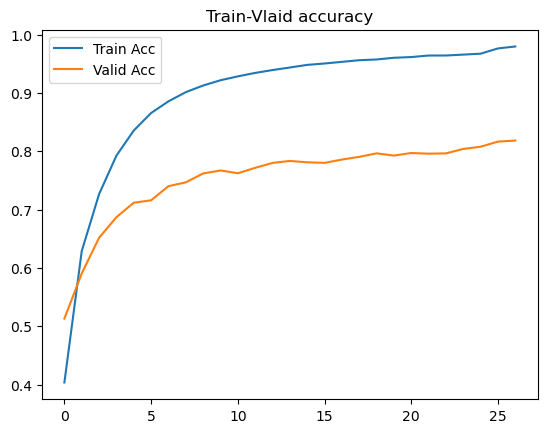

epoch 27 loss: 0.0563: 100%|████████████████| 6544/6544 [27:18<00:00,  3.99it/s]


train accuracy = 0.98028
[[2188    3    1 ...    0    0    0]
 [   5 2165   16 ...    0    0    0]
 [   1   23 2115 ...    0    0    0]
 ...
 [   0    0    0 ... 2171   24    0]
 [   0    0    0 ...   24 2171    0]
 [   0    0    0 ...    0    0 2198]]


epoch 27 loss: 0.8317: 100%|████████████████| 1860/1860 [03:25<00:00,  9.07it/s]


validation accuracy = 0.81505
[[260  10   8 ...   0   0   0]
 [  6 196  39 ...   0   1   0]
 [  6  33 412 ...   0   0   0]
 ...
 [  0   0   0 ... 168  10   0]
 [  1   0   0 ...  42 171   0]
 [  0   0   0 ...   0   0 219]]


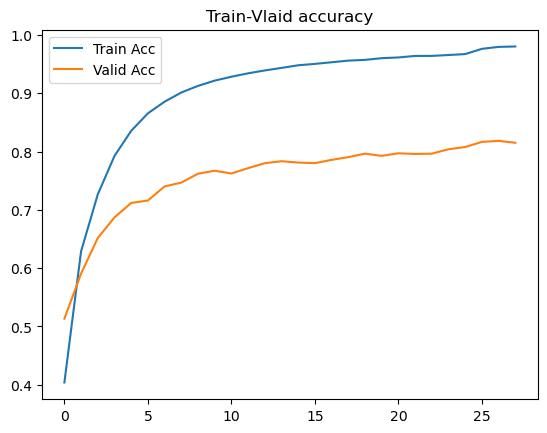

epoch 28 loss: 0.0702: 100%|████████████████| 6544/6544 [27:15<00:00,  4.00it/s]

train accuracy = 0.98139
[[2184    6    4 ...    0    0    0]
 [   5 2165   19 ...    0    0    0]
 [   4   28 2122 ...    0    0    0]
 ...
 [   0    0    0 ... 2175   22    0]
 [   0    0    0 ...   22 2168    0]
 [   0    0    0 ...    0    0 2195]]



epoch 28 loss: 0.7826: 100%|████████████████| 1860/1860 [03:23<00:00,  9.13it/s]


validation accuracy = 0.82490
[[255  19  10 ...   0   0   0]
 [  3 217  31 ...   0   1   0]
 [  4  39 428 ...   0   0   0]
 ...
 [  0   0   0 ... 166  13   0]
 [  0   0   0 ...  29 182   0]
 [  0   0   0 ...   0   0 213]]


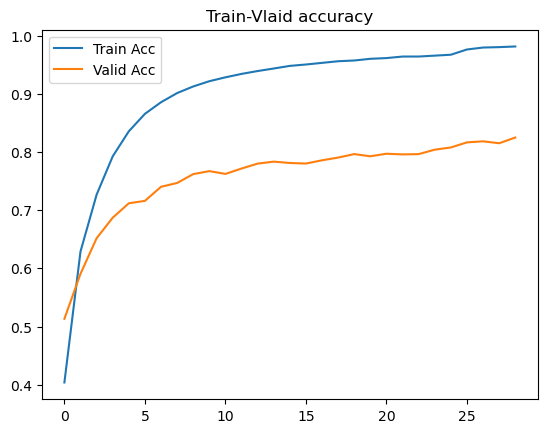

epoch 29 loss: 0.0702: 100%|████████████████| 6544/6544 [27:20<00:00,  3.99it/s]

train accuracy = 0.98192
[[2191    1    2 ...    0    0    0]
 [   4 2167   17 ...    0    0    0]
 [   2   16 2130 ...    0    0    0]
 ...
 [   0    0    0 ... 2175   19    0]
 [   0    0    0 ...   21 2171    0]
 [   0    0    0 ...    0    1 2195]]



epoch 29 loss: 0.8154: 100%|████████████████| 1860/1860 [03:23<00:00,  9.13it/s]


validation accuracy = 0.82554
[[274   6   7 ...   0   0   0]
 [  9 210  32 ...   0   1   0]
 [  8  24 423 ...   0   0   0]
 ...
 [  0   0   0 ... 164  16   0]
 [  0   0   1 ...  22 187   0]
 [  0   0   0 ...   0   0 215]]


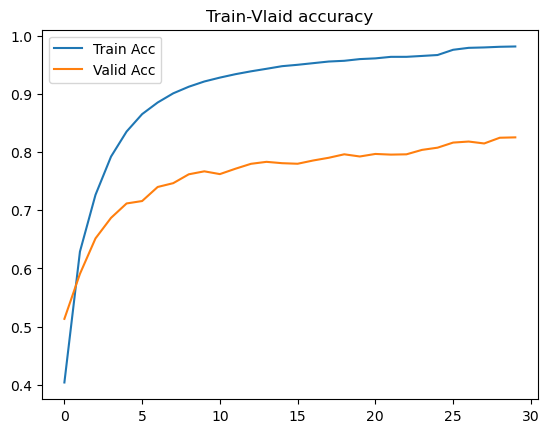

epoch 30 loss: 0.0683: 100%|████████████████| 6544/6544 [27:19<00:00,  3.99it/s]


train accuracy = 0.98266
[[2187    4    2 ...    0    0    0]
 [   5 2161   22 ...    0    0    0]
 [   0   18 2128 ...    0    0    0]
 ...
 [   0    0    0 ... 2185   13    0]
 [   0    0    0 ...   14 2180    0]
 [   0    0    0 ...    0    0 2199]]


epoch 30 loss: 0.8419: 100%|████████████████| 1860/1860 [03:23<00:00,  9.12it/s]


validation accuracy = 0.82167
[[269   8   7 ...   0   0   0]
 [  6 202  38 ...   0   1   0]
 [  6  29 429 ...   0   0   0]
 ...
 [  0   0   0 ... 165  11   0]
 [  1   0   1 ...  25 188   0]
 [  0   0   0 ...   0   0 214]]


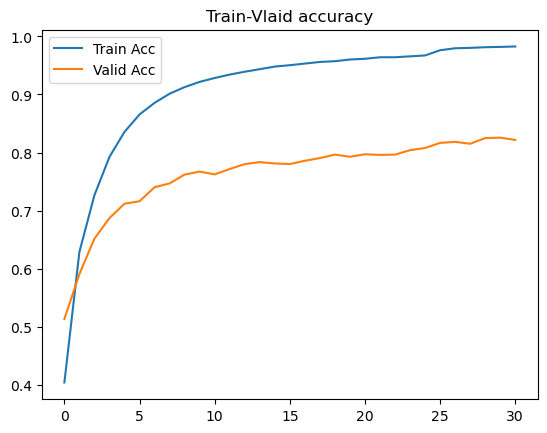

epoch 31 loss: 0.0743: 100%|████████████████| 6544/6544 [27:15<00:00,  4.00it/s]

train accuracy = 0.98339
[[2191    2    2 ...    0    0    0]
 [   2 2173   19 ...    0    0    0]
 [   2   24 2120 ...    0    0    0]
 ...
 [   0    0    0 ... 2180   12    0]
 [   0    0    0 ...   16 2173    0]
 [   0    0    0 ...    0    1 2198]]



epoch 31 loss: 0.8317: 100%|████████████████| 1860/1860 [03:23<00:00,  9.14it/s]


validation accuracy = 0.82440
[[270   9   8 ...   0   0   0]
 [ 11 199  40 ...   0   1   0]
 [  3  26 439 ...   0   0   0]
 ...
 [  0   0   0 ... 154  24   1]
 [  0   0   0 ...  27 190   0]
 [  0   0   0 ...   0   0 216]]


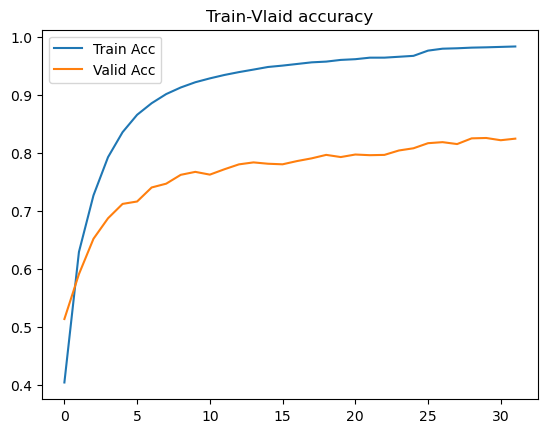

epoch 32 loss: 0.0566: 100%|████████████████| 6544/6544 [27:20<00:00,  3.99it/s]

train accuracy = 0.98368
[[2189    4    1 ...    0    0    0]
 [   3 2173   18 ...    0    0    0]
 [   2   20 2136 ...    0    0    0]
 ...
 [   0    0    0 ... 2180   13    0]
 [   0    0    0 ...   13 2178    0]
 [   0    0    0 ...    1    0 2198]]



epoch 32 loss: 0.8397: 100%|████████████████| 1860/1860 [03:24<00:00,  9.10it/s]


validation accuracy = 0.82046
[[268   7   7 ...   0   0   0]
 [  7 202  42 ...   0   1   0]
 [  5  30 434 ...   0   0   0]
 ...
 [  0   0   0 ... 161  11   0]
 [  1   0   0 ...  22 189   0]
 [  0   0   0 ...   0   0 218]]


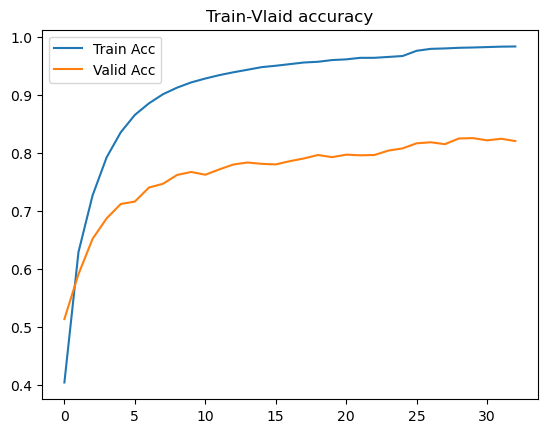

epoch 33 loss: 0.0553: 100%|████████████████| 6544/6544 [27:31<00:00,  3.96it/s]

train accuracy = 0.98429
[[2189    3    2 ...    0    0    0]
 [   5 2169   20 ...    0    0    0]
 [   0   22 2141 ...    0    0    0]
 ...
 [   0    0    0 ... 2171   22    0]
 [   0    0    1 ...   24 2169    0]
 [   0    0    0 ...    0    0 2199]]



epoch 33 loss: 0.8747: 100%|████████████████| 1860/1860 [03:23<00:00,  9.14it/s]


validation accuracy = 0.81707
[[267  12  11 ...   0   0   0]
 [  4 216  26 ...   0   1   0]
 [  9  41 406 ...   0   0   0]
 ...
 [  0   0   0 ... 163  10   0]
 [  1   0   0 ...  35 178   0]
 [  0   0   0 ...   0   0 217]]


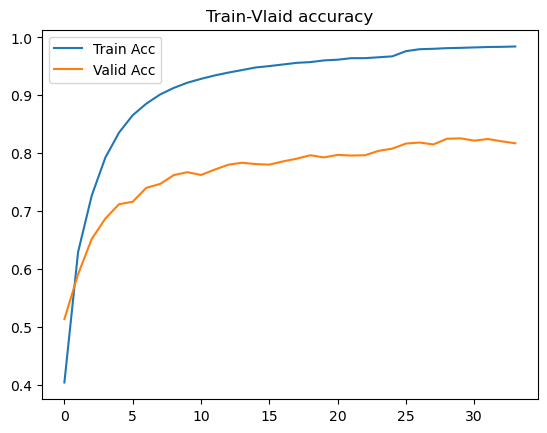

epoch 34 loss: 0.0609: 100%|████████████████| 6544/6544 [27:23<00:00,  3.98it/s]

train accuracy = 0.98507
[[2187    3    2 ...    0    0    0]
 [   2 2168   16 ...    0    0    0]
 [   4   22 2127 ...    0    0    0]
 ...
 [   0    0    0 ... 2181   13    0]
 [   0    0    0 ...   18 2179    0]
 [   0    0    0 ...    0    1 2201]]



epoch 34 loss: 0.8917: 100%|████████████████| 1860/1860 [03:23<00:00,  9.12it/s]


validation accuracy = 0.82285
[[273   8   6 ...   0   0   0]
 [  1 210  36 ...   0   1   0]
 [  3  31 439 ...   0   0   0]
 ...
 [  0   0   0 ... 161   9   0]
 [  0   0   0 ...  27 182   0]
 [  0   0   0 ...   0   0 217]]


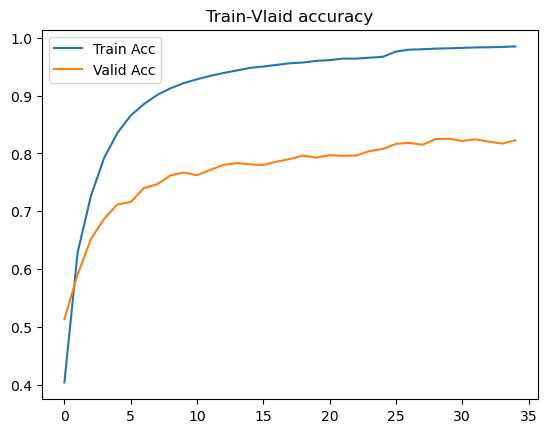

epoch 35 loss: 0.0620: 100%|████████████████| 6544/6544 [27:28<00:00,  3.97it/s]

train accuracy = 0.98519
[[2189    3    2 ...    0    0    0]
 [   2 2175   13 ...    0    0    0]
 [   1   19 2138 ...    0    0    0]
 ...
 [   0    0    0 ... 2180   16    0]
 [   0    0    0 ...   13 2178    0]
 [   0    0    0 ...    0    0 2198]]



epoch 35 loss: 0.9045: 100%|████████████████| 1860/1860 [03:24<00:00,  9.11it/s]


validation accuracy = 0.81680
[[261   9  12 ...   0   0   0]
 [  3 201  44 ...   0   1   0]
 [  1  23 444 ...   0   0   0]
 ...
 [  0   0   0 ... 156  14   0]
 [  1   0   0 ...  19 190   0]
 [  0   0   0 ...   0   0 219]]


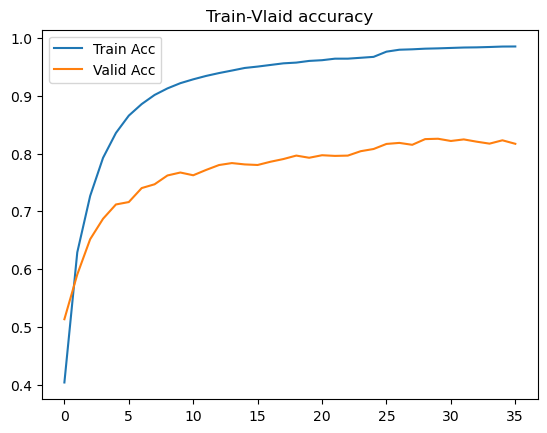

epoch 36 loss: 0.0555: 100%|████████████████| 6544/6544 [27:34<00:00,  3.96it/s]

train accuracy = 0.98561
[[2187    4    3 ...    0    0    0]
 [   2 2177   16 ...    0    0    0]
 [   2   24 2128 ...    0    0    0]
 ...
 [   0    0    0 ... 2171   19    0]
 [   0    0    0 ...   21 2176    0]
 [   0    0    0 ...    0    0 2198]]



epoch 36 loss: 0.8760: 100%|████████████████| 1860/1860 [03:24<00:00,  9.12it/s]


validation accuracy = 0.82268
[[280   1   6 ...   0   0   0]
 [ 14 199  41 ...   0   1   0]
 [  3  31 425 ...   0   0   0]
 ...
 [  0   0   0 ... 165  10   0]
 [  0   0   0 ...  35 179   0]
 [  0   0   0 ...   0   0 221]]


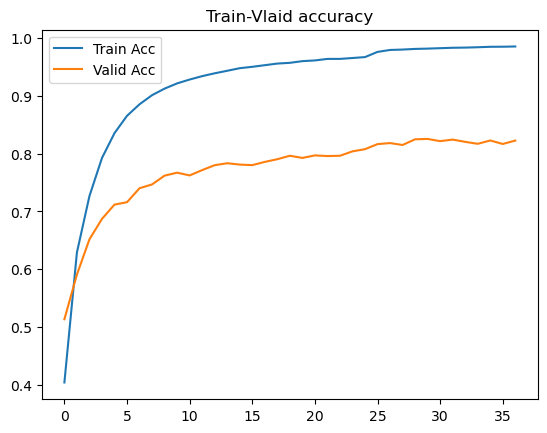

epoch 37 loss: 0.0486: 100%|████████████████| 6544/6544 [27:31<00:00,  3.96it/s]

train accuracy = 0.98566
[[2189    4    1 ...    0    0    0]
 [   4 2168   19 ...    0    0    0]
 [   1   21 2140 ...    0    0    0]
 ...
 [   0    0    0 ... 2180   18    0]
 [   0    0    0 ...   21 2167    0]
 [   0    0    0 ...    0    0 2201]]



epoch 37 loss: 0.8833: 100%|████████████████| 1860/1860 [03:24<00:00,  9.12it/s]


validation accuracy = 0.82443
[[273   5   8 ...   0   0   0]
 [  8 215  30 ...   0   0   0]
 [  8  37 422 ...   0   0   0]
 ...
 [  0   0   0 ... 157  16   0]
 [  0   0   0 ...  24 188   0]
 [  0   0   0 ...   0   0 217]]


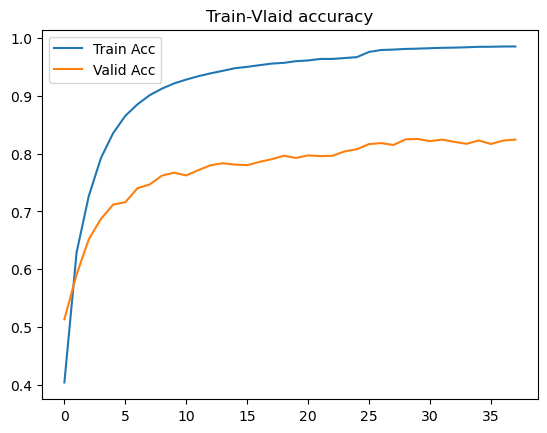

epoch 38 loss: 0.0530: 100%|████████████████| 6544/6544 [27:35<00:00,  3.95it/s]

train accuracy = 0.98635
[[2188    5    1 ...    0    0    0]
 [   6 2174    9 ...    0    0    0]
 [   2   16 2141 ...    0    0    0]
 ...
 [   0    0    0 ... 2180   15    0]
 [   0    0    0 ...   14 2181    0]
 [   0    0    0 ...    0    0 2198]]



epoch 38 loss: 0.8919: 100%|████████████████| 1860/1860 [03:24<00:00,  9.11it/s]


validation accuracy = 0.82050
[[264   6   9 ...   0   0   0]
 [ 10 217  28 ...   0   1   0]
 [  1  42 409 ...   0   0   0]
 ...
 [  0   0   0 ... 161  10   0]
 [  0   0   0 ...  25 188   0]
 [  0   0   0 ...   0   0 221]]


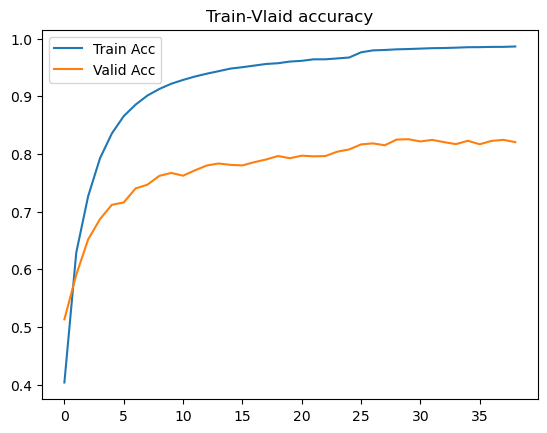

epoch 39 loss: 0.0549: 100%|████████████████| 6544/6544 [27:38<00:00,  3.95it/s]

train accuracy = 0.98639
[[2192    3    3 ...    0    0    0]
 [   4 2177   14 ...    0    0    0]
 [   1   13 2146 ...    0    0    0]
 ...
 [   0    0    0 ... 2184   11    0]
 [   0    0    0 ...    9 2188    0]
 [   0    0    0 ...    0    0 2196]]



epoch 39 loss: 0.8756: 100%|████████████████| 1860/1860 [03:24<00:00,  9.11it/s]


validation accuracy = 0.82349
[[271   8   6 ...   0   1   0]
 [  6 205  37 ...   0   1   0]
 [  7  33 426 ...   0   0   0]
 ...
 [  0   0   0 ... 160  12   0]
 [  0   0   0 ...  29 188   0]
 [  0   0   0 ...   0   0 215]]


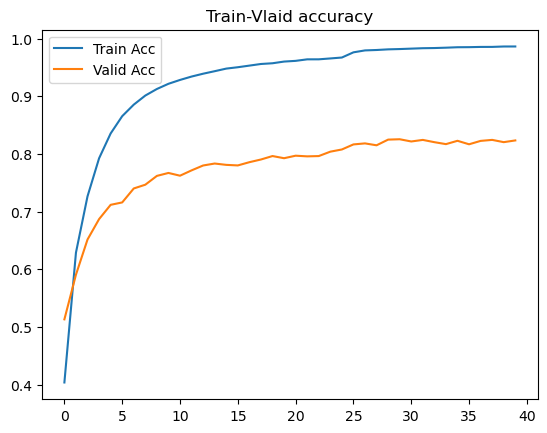

time : 20:19:05
Best Epoch : 29/ 40
Best Train Accuracy : 0.98192
[[2191    1    2 ...    0    0    0]
 [   4 2167   17 ...    0    0    0]
 [   2   16 2130 ...    0    0    0]
 ...
 [   0    0    0 ... 2175   19    0]
 [   0    0    0 ...   21 2171    0]
 [   0    0    0 ...    0    1 2195]]
Best Valid Accuracy : 0.82554
[[274   6   7 ...   0   0   0]
 [  9 210  32 ...   0   1   0]
 [  8  24 423 ...   0   0   0]
 ...
 [  0   0   0 ... 164  16   0]
 [  0   0   1 ...  22 187   0]
 [  0   0   0 ...   0   0 215]]


AttributeError: 'DataParallel' object has no attribute 'cnn_model'

AttributeError: 'DataParallel' object has no attribute 'cnn_model'

In [36]:
%run classification_train_efficientnet2.ipynb

In [18]:
print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 38/ 40
Best Train Accuracy : 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]
Best Valid Accuracy : 0.88483
[[255  10   2 ...   0   0   0]
 [  6 196   0 ...   0   0   0]
 [  3   0 389 ...   0   0   0]
 ...
 [  0   0   0 ... 178   5   0]
 [  0   0   0 ...  12 208   0]
 [  0   0   0 ...   0   0 218]]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


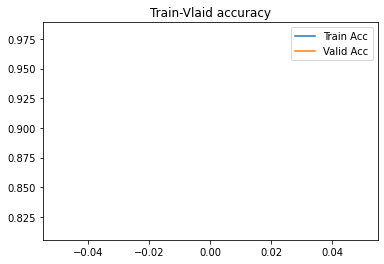

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


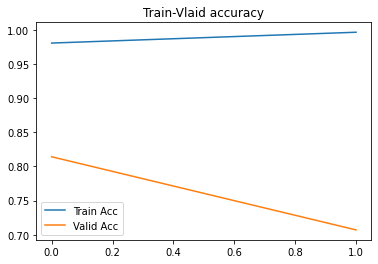

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


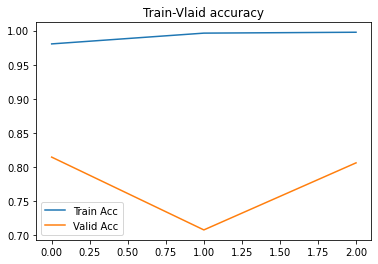

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


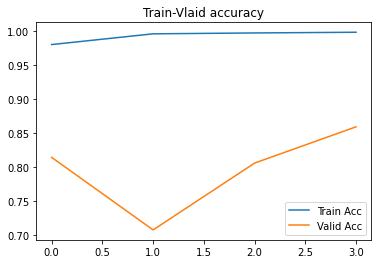

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


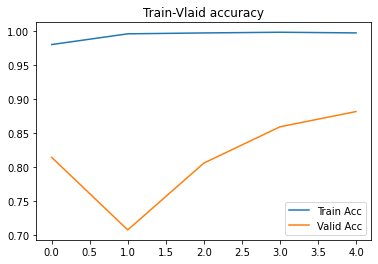

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb